In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 102.5 MB/s eta 0:00:0000:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.


In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [4]:
#Enabling memory growth for GPU
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import tensorflow as tf
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
import IPython
import IPython.display
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dataclasses import dataclass
import pandas as pd
import numpy as np
import keras_tuner as kt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU
import gc
from tensorflow.keras.callbacks import Callback

In [6]:
# for reproducibility
seed0=1337
np.random.seed(seed0) 
tf.keras.utils.set_random_seed(seed0)
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(seed0)

In [7]:
#to avoid seeing shortened text data in pandas cell
pd.set_option('display.max_colwidth', None)

In [8]:
#reading datasets
train=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
holiday_events=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
oil=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
stores=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
transactions=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")

In [9]:
#converting date feature to datetime data type
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
holiday_events["date"] = pd.to_datetime(holiday_events.date)
oil["date"] = pd.to_datetime(oil.date)
transactions["date"] = pd.to_datetime(transactions.date)

In [10]:
# helper function to do merge datasets 
def joins(df,holiday_events,oil,stores):
    print(df.shape)
    holiday_events=holiday_events.drop_duplicates(subset=['date'], keep='last')
    df_holiday=pd.merge(df,holiday_events,how="left",on='date', validate="many_to_one")
    print(f"Shape after merging with holiday {df_holiday.shape}")
    df_holiday_oil=pd.merge(df_holiday,oil,how="left",on='date')
    print(f"Shape after merging with holiday + oil {df_holiday_oil.shape}")
    df_holiday_oil_stores=pd.merge(df_holiday_oil,stores,how="left",on="store_nbr",suffixes=("holiday","stores"))
    print(f"Shape after merging with holiday + oil + stores {df_holiday_oil_stores.shape}")
    return df_holiday_oil_stores

In [11]:
#merging datasets
train_merged=joins(train,holiday_events,oil,stores)
display(train_merged.head(1),train_merged.tail(1))
test_merged=joins(test,holiday_events,oil,stores)
display(test_merged.head(1),test_merged.tail(1))

(3000888, 6)
Shape after merging with holiday (3000888, 11)
Shape after merging with holiday + oil (3000888, 12)
Shape after merging with holiday + oil + stores (3000888, 16)


,id,date,store_nbr,family,sales,onpromotion,typeholiday,locale,locale_name,description,transferred,dcoilwtico,city,state,typestores,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13


,id,date,store_nbr,family,sales,onpromotion,typeholiday,locale,locale_name,description,transferred,dcoilwtico,city,state,typestores,cluster
3000887,3000887,2017-08-15,9,SEAFOOD,16.0,0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6


(28512, 5)
Shape after merging with holiday (28512, 10)
Shape after merging with holiday + oil (28512, 11)
Shape after merging with holiday + oil + stores (28512, 15)


,id,date,store_nbr,family,onpromotion,typeholiday,locale,locale_name,description,transferred,dcoilwtico,city,state,typestores,cluster
0,3000888,2017-08-16,1,AUTOMOTIVE,0,NaN,NaN,NaN,NaN,NaN,46.8,Quito,Pichincha,D,13


,id,date,store_nbr,family,onpromotion,typeholiday,locale,locale_name,description,transferred,dcoilwtico,city,state,typestores,cluster
28511,3029399,2017-08-31,9,SEAFOOD,0,NaN,NaN,NaN,NaN,NaN,47.26,Quito,Pichincha,B,6


In [12]:
# extracting time features for train dataset
train_merged['day_of_week'] = train_merged['date'].dt.day_of_week
train_merged['day_of_week'] = train_merged['day_of_week']+1
train_merged['month'] = train_merged['date'].dt.month
train_merged['year'] = train_merged['date'].dt.year

In [13]:
# extracting time features for test dataset
test_merged['day_of_week'] = test_merged['date'].dt.day_of_week
test_merged['day_of_week'] = test_merged['day_of_week']+1
test_merged['month'] = test_merged['date'].dt.month
test_merged['year'] = test_merged['date'].dt.year

In [14]:
# helper function to convert transfered holidays to normal days
def transfer_holiday_fix(df):
    df["typeholiday"]=np.where(df["transferred"]==True,'NDay',df["typeholiday"])
    df["typeholiday"]=np.where(df["typeholiday"]=='Work Day','NDay',df["typeholiday"])
    df["typeholiday"]=df["typeholiday"].fillna("NDay")
    return df

In [15]:
train_merged=transfer_holiday_fix(train_merged)
test_merged=transfer_holiday_fix(test_merged)
# checking new structure of holiday type column
display(train_merged["typeholiday"].value_counts(dropna=False))
display(test_merged["typeholiday"].value_counts(dropna=False))

typeholiday
NDay          2576772
Holiday        247698
Event           98010
Additional      58806
Transfer        16038
Bridge           3564
Name: count, dtype: int64

typeholiday
NDay       26730
Holiday     1782
Name: count, dtype: int64

In [16]:
#helper function to remove id columns used for joining datasets, 
# note I made decision not to use store_nbr, because I am not using transactions to extract features
# but it can work as category feature for certain models, 
# my decision was because it is an idendifier and useful information it contains also exist in store type and cluster
def select_relevant(df):
    print(f"shape before removing columns {df.shape}")
    features=["date","family","sales","onpromotion","typeholiday","dcoilwtico","city","state",
              "typestores","cluster","day_of_week","month","year"]
    if "sales" in df.columns:
        df= df[features]
    else:
        features.remove("sales")
        df= df[features]
    print(f"Shape after removing columns {df.shape}")
    return df

In [17]:
train_merged=select_relevant(train_merged)
test_merged=select_relevant(test_merged)

shape before removing columns (3000888, 19)
Shape after removing columns (3000888, 13)
shape before removing columns (28512, 18)
Shape after removing columns (28512, 12)


In [18]:
# helper function to interpolate oil price
def interpolate_oil(df):
    print(f"Shape before interpolating {df.shape}")
    df["dcoilwtico"]=np.where(df["dcoilwtico"] ==0, np.nan, df["dcoilwtico"])
    df.dcoilwtico.interpolate(limit_direction='both',inplace=True)
    print(f"Shape after interpolating {df.shape}")
    return df

In [19]:
train_merged=interpolate_oil(train_merged)
test_merged=interpolate_oil(test_merged)
display(f"Number of nan in train dataset oil price after interpolation {train_merged['dcoilwtico'].isna().sum()}")
display(f"Number of nan in test dataset oil price after interpolation {test_merged['dcoilwtico'].isna().sum()}")

Shape before interpolating (3000888, 13)
Shape after interpolating (3000888, 13)
Shape before interpolating (28512, 12)
Shape after interpolating (28512, 12)


'Number of nan in train dataset oil price after interpolation 0'

'Number of nan in test dataset oil price after interpolation 0'

In [20]:
# helper function to extract the features I potentially use for training a model
def extract_features(df):
    print(f"Shape before extracting {df.shape}")
    useful_features=['date', 'family','onpromotion','typeholiday', 'dcoilwtico','city', 'typestores', 'cluster','day_of_week', 'month','year']
    if "sales"in df.columns:
        df=df[useful_features+["sales"]]
    else:
        df=df[useful_features]
    print(f"Shape after extracting{df.shape}")
    return df

In [21]:
train_merged=extract_features(train_merged)
test_merged=extract_features(test_merged)

Shape before extracting (3000888, 13)
Shape after extracting(3000888, 12)
Shape before extracting (28512, 12)
Shape after extracting(28512, 11)


In [22]:
# converting category columns to str type
category_columns=['family', 'typeholiday', 'city', 'typestores', 'cluster']
for column in category_columns:
    train_merged[column] = train_merged[column].astype('str')
    test_merged[column] = test_merged[column].astype('str')

In [23]:
# converting extracted time features to float
time_columns=["month","day_of_week","year"]
for column in time_columns:
    train_merged[column] = train_merged[column].astype('float')
    test_merged[column] = test_merged[column].astype('float')

In [24]:
# saving them in to a csv
train_merged.to_csv('train_merged.csv', index=False)
test_merged.to_csv('test_merged.csv', index=False)

In [25]:
#main modules for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import TargetEncoder

#main modules for designing ML pipeliens
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer 
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

#main module for evaluation
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error,r2_score

In [26]:
# helper function to calculate regression metrics
def calcMetrics(testActualVal, predictions):
    #regression evaluation measures
    data={"RMSLE":[mean_squared_log_error(testActualVal, predictions)**0.5],
         "MAE":[mean_absolute_error(testActualVal, predictions)],
         "RMSE":[mean_squared_error(testActualVal, predictions)**0.5],
         "R2":[r2_score(testActualVal, predictions)]}
    metric_df=pd.DataFrame(data)
    return metric_df

# DNN Model : Univariate LSTM - CNN hybrit model
To incorporate impact of category features into lstm-cnn hybrid dnn, I will create a feature by merging 3 most important category feature together
To train a dnn for each class in this new featrue, first I will discretise target encode new_feature, then discretise it into bins. This will group classes with similar sales figures together and reduce the number of models needed to be trained

In [27]:
# making a copy of dataset I prepered before for training
dnn_df=train_merged.copy()
df_dnn_test_check=test_merged.copy()
# removing the 2nd copy to free memory
del train_merged
del test_merged
dnn_df["cat_gen"]=dnn_df["family"]+dnn_df["city"]+dnn_df["cluster"]
display(f'store_nbr nunique: {train["store_nbr"].nunique()}, family nunique: {dnn_df["family"].nunique()}, city nunique: {dnn_df["city"].nunique()}, cluster nunique: {dnn_df["cluster"].nunique()}, cat_gen nunique: {dnn_df["cat_gen"].nunique()}')


'store_nbr nunique: 54, family nunique: 33, city nunique: 22, cluster nunique: 17, cat_gen nunique: 1353'

In [28]:
col_names_dnn=['cat_gen', 'date']
dnn_df_x=dnn_df[col_names_dnn]
dnn_df_y=dnn_df["sales"]

In [29]:
# sub pipeline to apply said transformation on derived feature
category_feat_dnn=Pipeline(steps=[("target_encode",TargetEncoder(target_type="continuous")),
                                 ("combiner",KBinsDiscretizer(n_bins=130, strategy='kmeans',
                                  subsample=None, random_state=seed0,encode='ordinal'))
                                 ])

In [30]:
# engineering the said feature in pipeline
preprocess_pipe_dnn = Pipeline(steps=[
    ('encoder', ColumnTransformer(
                    transformers=[
                        ("category_trans",category_feat_dnn,["cat_gen"])
                                ],
                                remainder="passthrough", verbose_feature_names_out=True
                            )),
    ("pandarizer2", FunctionTransformer(lambda x: pd.DataFrame(x, columns =  col_names_dnn)))
                            ],verbose = True)

In [31]:
# converting date to string to avoid it getting transformed to float
dnn_df_x = dnn_df_x.astype({'date':'string'})
preprocess_pipe_dnn.fit(dnn_df_x,dnn_df_y)

[Pipeline] ........... (step 1 of 2) Processing encoder, total=  28.7s
[Pipeline] ....... (step 2 of 2) Processing pandarizer2, total=   0.0s


Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('category_trans',
                                                  Pipeline(steps=[('target_encode',
                                                                   TargetEncoder(target_type='continuous')),
                                                                  ('combiner',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=130,
                                                                                    random_state=1337,
                                                                                    strategy='kmeans',
                                                                                    subsample=None))]),
                                                  ['cat_gen'])])),
                ('pandarizer2',
                 FunctionTransformer(func=<function <lambda> at 0x7deb633d7400>))],
         verbose=True)

In [32]:
dnn_df_x=preprocess_pipe_dnn.transform(dnn_df_x)

In [33]:
dnn_training_features= ['cat_gen', 'date']
dnn_df_x=dnn_df_x[dnn_training_features]
#concatenating X-y datasets
dnn_df_processed=pd.concat([dnn_df_x,dnn_df_y], axis=1)
# converting date to datetime dtype
dnn_df_processed["date"] = pd.to_datetime(dnn_df_processed.date)
dnn_df_processed["sales"] = dnn_df_processed["sales"].astype(np.float32)

In [34]:
# checking number of samples in each class of derived feature
display(dnn_df_processed["cat_gen"].value_counts() , dnn_df_processed["cat_gen"].nunique())

cat_gen
0.0      1394352
1.0       276176
2.0       161664
5.0       138088
4.0       119564
          ...   
73.0        1684
115.0       1684
128.0       1684
52.0        1684
30.0        1684
Name: count, Length: 98, dtype: int64

98

In [35]:
# applying the same transformations to test dataset
df_dnn_test_check["cat_gen"]=df_dnn_test_check["family"]+df_dnn_test_check["city"]+df_dnn_test_check["cluster"]
df_dnn_test_check = df_dnn_test_check.astype({'date':'string'})
df_dnn_test_check=preprocess_pipe_dnn.transform(df_dnn_test_check)
df_dnn_test_check=df_dnn_test_check[dnn_training_features]
df_dnn_test_check["date"] = pd.to_datetime(df_dnn_test_check.date)
# checking if train have any class that test don't have, if so I will remove it
display(f"test: {df_dnn_test_check['cat_gen'].nunique()} number of class in the derived category")
display(f"train: {dnn_df_processed['cat_gen'].nunique()} number of class in the derived category")

'test: 98 number of class in the derived category'

'train: 98 number of class in the derived category'

In [36]:
# I will use the 95 day from end of train dataset time series for validation 
Test_sample_size=95
SPLIT_DATE=pd.to_datetime("2017-08-15")-pd.to_timedelta((Test_sample_size), unit='d')
Train_sample_size =365*4+1
Training_interval=pd.to_timedelta((Train_sample_size), unit='d')
train_data_begin_date=SPLIT_DATE-Training_interval
display(f"train_data_begin_date: {train_data_begin_date}")
dnn_df_processed=dnn_df_processed.loc[dnn_df_processed["date"]>=train_data_begin_date]
display(dnn_df_processed.head(2))
#creating a copy of processed dataset for ease of access to unscaled features for later comparison, evaluation
dnn_df_processed_unscaled=dnn_df_processed.copy()
grouped_sample_lenght=len(dnn_df_processed_unscaled[dnn_df_processed_unscaled["cat_gen"]==0].groupby("date")[['cat_gen','sales']].agg({'cat_gen':'mean', 'sales':'median'}))
display(f"lenght of dataframes grouped by cat_gen: {grouped_sample_lenght}")

'train_data_begin_date: 2013-05-12 00:00:00'

,cat_gen,date,sales
233442,0.0,2013-05-12,1.0
233443,0.0,2013-05-12,0.0


'lenght of dataframes grouped by cat_gen: 1553'

In [37]:
#defining parameters for training
SPLIT_TIME =grouped_sample_lenght-Test_sample_size
WINDOW_SIZE = 16
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 580

In [38]:
def create_datasets(df):
    dnn_data_sets={}
    fitted_scalers={}
    for val in df["cat_gen"].unique():
        df_segment=df[df["cat_gen"]==val]
        df_segment_grouped=df_segment.groupby("date")[['cat_gen','sales']].agg({'cat_gen':'mean', 'sales':'median'})
        df_segment_grouped=df_segment_grouped.drop(columns=['cat_gen'])
        scaler=MinMaxScaler()
        scaler.fit(df_segment_grouped[["sales"]])
        fitted_scalers[val]=scaler
        df_segment_grouped["sales"]=scaler.transform(df_segment_grouped[["sales"]])
        df_segment_grouped["sales"] = df_segment_grouped["sales"].astype(np.float32)
        dnn_data_sets[val]=df_segment_grouped
    return dnn_data_sets , fitted_scalers
dnn_data_sets, fitted_scalers=create_datasets(dnn_df_processed) 

In [39]:
# printing a sample of sub-datasets shape info
Sample_of_df_dict=np.random.choice([x for x in dnn_data_sets.keys()], 10 ,replace=False)
for key in Sample_of_df_dict:
    display(f"{key} : {dnn_data_sets[key].shape}")


'17.0 : (1553, 1)'

'36.0 : (1553, 1)'

'12.0 : (1553, 1)'

'3.0 : (1553, 1)'

'77.0 : (1553, 1)'

'103.0 : (1553, 1)'

'28.0 : (1553, 1)'

'5.0 : (1553, 1)'

'96.0 : (1553, 1)'

'54.0 : (1553, 1)'

In [40]:
# verifying number of samples to be used for training and validation
len_test=len(dnn_data_sets[0][dnn_data_sets[0].index <=SPLIT_DATE])
display(f"train size: {len_test}, test size: {dnn_data_sets[0].shape[0]-len_test}")

'train size: 1458, test size: 95'

In [41]:
# helper function to parse dataframes to extract time and series
def parse_df(df):
    times =np.array([x for x in range(df.shape[0])])
    series=df["sales"].to_numpy()
    return times, series

In [42]:
# helper function to devide time and series to train test splits according to time-step
def train_val_split(time, series, time_step):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]
    return time_train, series_train, time_valid, series_valid

In [43]:
# helper function to create windowed dataset tensors from series by shifting according to window size 
# and create batches from it for training
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [44]:
tf.keras.backend.clear_session()
# helper function to create and compile dnn model
def create_model(WINDOW_SIZE):
    drop_out=0
    activation=LeakyReLU(alpha = 0.01)
    regularizer=regularizers.l2(1e-4)
    model = tf.keras.models.Sequential([
              #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
              #            input_shape=[WINDOW_SIZE]),
              tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                          strides=1,
                          activation=activation,
                          padding='causal',
                          input_shape=[WINDOW_SIZE, 1]),
              tf.keras.layers.LSTM(64, return_sequences=True, dropout=drop_out),
              tf.keras.layers.LSTM(64,dropout=drop_out),
              tf.keras.layers.Dense(30, activation=activation, kernel_regularizer = regularizer),
              tf.keras.layers.Dense(10, activation=activation, kernel_regularizer = regularizer),
              tf.keras.layers.Dense(1)
        ])
    learning_rate = 1e-3
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["mae"])
    return model

In [45]:
# callback function to avoid any memory leak issue and reset states in tf.keras
class ClearMemory(Callback):
    def on_train_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

In [46]:
# call back function to avoid overfitting by early stopping and reduce learning rate on plateau to help convergence
def call():
    #early stopping
    es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # metrics to monitor
    patience=20, # how many epochs before stop
    verbose=1,
    mode='min', 
    restore_best_weights=True)
    
    # reducing learning rate on plateau
    rp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, # halving learning rate on plateau
    patience=3,
    verbose=1,
    mode='min',
    min_lr=1e-8)
    return es,rp

In [47]:
# generator function to iterate memory efficently
def ited_dict(dict):
    for key,value in dict.items():
        yield key, value

In [48]:
def train_all(dnn_data_sets,WINDOW_SIZE,BATCH_SIZE,SHUFFLE_BUFFER_SIZE, SPLIT_TIME):
    compiled_models_dict={}
    history_dict={}
    total_num_models=len(dnn_data_sets)
    num_model_to_train=total_num_models
    for key,df in ited_dict(dnn_data_sets):
        print(f"Number of models remained to be trained {num_model_to_train} out of {total_num_models} remained")
        print(f"Training: {key}")
        times, sales = parse_df(df)
        TIME = np.array(times)
        SERIES = np.array(sales)
        
        time_train, series_train, time_valid, series_valid =train_val_split(TIME, SERIES, time_step=SPLIT_TIME)
        
        train_set = windowed_dataset(series_train, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, 
                                     shuffle_buffer=SHUFFLE_BUFFER_SIZE)
        
        valid_set = windowed_dataset(series_valid, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, 
                             shuffle_buffer=SHUFFLE_BUFFER_SIZE)
        
        model = create_model(WINDOW_SIZE)
        callbacks = call()
        history = model.fit(train_set, epochs=100, verbose=1,validation_data=valid_set, callbacks=[callbacks,ClearMemory()])
        compiled_models_dict[key]=model
        del model
        history_dict[key]=history
        del history
        num_model_to_train-=1
        IPython.display.clear_output()
        gc.collect()
        tf.keras.backend.clear_session()
    print(f"Trainings finnished: {len(compiled_models_dict)} models trained.")        
    return compiled_models_dict, history_dict

In [49]:
compiled_models_dict, history_dict=train_all(dnn_data_sets,WINDOW_SIZE,BATCH_SIZE,SHUFFLE_BUFFER_SIZE, SPLIT_TIME)

Trainings finnished: 98 models trained.


In [53]:
# helper function for to create windowed dataset without shuffling for fast forecasting 
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(8).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [54]:
def predict_results(models_dict,dnn_data_sets, WINDOW_SIZE,SPLIT_TIME,fitted_scalers):
    predictions={}
    total_num_models=len(dnn_data_sets)
    num_model_to_train=total_num_models
    for key,model in ited_dict(models_dict):
        print(f"Number of datasets remained to be predicted {num_model_to_train} out of {total_num_models} remained")
        print(f"Predicting: {key}")
        times, sales = parse_df(dnn_data_sets[key])
        TIME = np.array(times)
        SERIES = np.array(sales)
        
        dnn_forecast = model_forecast(model,SERIES, WINDOW_SIZE).squeeze()
        dnn_forecast = dnn_forecast[SPLIT_TIME - WINDOW_SIZE:-1]
        
        predictions_df=pd.DataFrame(index=dnn_data_sets[key][SPLIT_TIME :].index)
        predictions_df["predictions"]=dnn_forecast
        del dnn_forecast
        predictions_df["predictions"]=fitted_scalers[key].inverse_transform(predictions_df[["predictions"]])
        predictions_df["predictions"]=np.where(predictions_df["predictions"]<0,0,predictions_df["predictions"])
        predictions[key]=predictions_df
        num_model_to_train-=1
        IPython.display.clear_output()
        gc.collect()
    print(f"Predictions finnished: {len(predictions)} dataset predicted.") 
    return predictions

In [55]:
predictions_dict=predict_results(compiled_models_dict,dnn_data_sets, WINDOW_SIZE,SPLIT_TIME, fitted_scalers)

Predictions finnished: 98 dataset predicted.


In [56]:
# helper function for mapping predictions from sub-grouped datasets to ungrouped full dataset 
def aggragate_predictions(df_valid,predictions_dict):
    df_preds = pd.DataFrame(columns=['predictions'], index=df_valid.index.copy())
    for key,df in ited_dict(predictions_dict):
        for date in df.index:
            df_preds["predictions"]=np.where((df_valid["cat_gen"]==key) & (df_valid["date"]==date),
                                                   df.iloc[df.index.values==date]["predictions"].values[0] ,df_preds["predictions"])
    return df_preds["predictions"].to_numpy()

In [57]:
# helper function for creating ungrouped full validation dataset and parsing it into X and y
def val_dnn_processed(df):
    val_start_index=df.shape[0]-len(df["date"][df["date"] >SPLIT_DATE])
    val=df[val_start_index:]
    y_valid = val.pop("sales")
    X_valid = val
    return X_valid, y_valid 
X_valid_dnn, y_valid_dnn = val_dnn_processed(dnn_df_processed_unscaled)

In [58]:
# predicting full-validation datase and calculating metrics
y_pred_dnn=aggragate_predictions(X_valid_dnn,predictions_dict)
calcMetrics(y_pred_dnn,y_valid_dnn)


,RMSLE,MAE,RMSE,R2
0,0.902553,131.352631,456.289673,0.863431


In [64]:
#helper function to plot time series actual vs time series predicted 
def plot_series_multi(time1, series1,series2,label1, label2, format1="--",format2="-", start=0, end=None ):
    fig = plt.figure(figsize=(14,5))
    ax = fig.add_axes([1, 1, 1, 1])
    ax.plot(time1[start:end], series1[start:end])
    ax.plot(time1[start:end], series2[start:end])
    ax.legend(labels = (label1, label2),fontsize=15)
    plt.xlabel("Time",fontsize=15)
    plt.ylabel("Sales",fontsize=15)
    plt.grid(True)
    plt.show()
    plt.close()

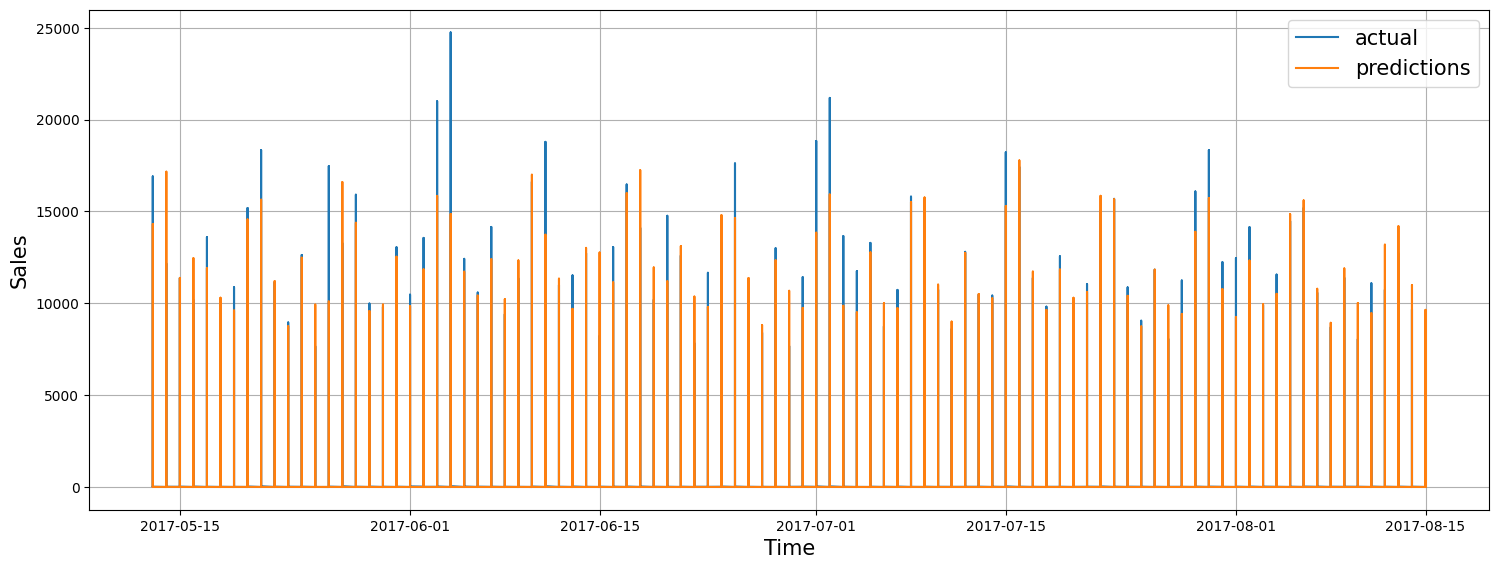

In [65]:
# plotting actual vs predictions for validation dataset
plot_series_multi(dnn_df_processed_unscaled.loc[dnn_df_processed_unscaled["date"]>SPLIT_DATE]["date"].values,
                   dnn_df_processed_unscaled.loc[dnn_df_processed_unscaled["date"]>SPLIT_DATE]["sales"].values, y_pred_dnn,
                  "actual","predictions",format1='r^',format2="b^", start=0, end=None )

In [66]:
# helper function to devide test into sub-datasets for each class in derived category
def create_grouped_test_datasets(df):
    dnn_data_sets={}
    for val in df["cat_gen"].unique():
        df_segment=df[df["cat_gen"]==val]
        df_segment_grouped=df_segment.groupby("date")[['cat_gen']].agg({'cat_gen':'mean'})
        df_segment_grouped=df_segment_grouped.drop(columns=['cat_gen'])
        dnn_data_sets[val]=df_segment_grouped
    return dnn_data_sets 
dnn_data_set_test =create_grouped_test_datasets(df_dnn_test_check) 

In [67]:
def predict_results_test(models_dict,dnn_data_sets,dnn_data_set_test, WINDOW_SIZE,fitted_scalers):
    predictions={}
    for key, model in models_dict.items():
        times, sales = parse_df(dnn_data_sets[key])
        SERIES = np.array(sales)
        dnn_forecast = model_forecast(model,SERIES, WINDOW_SIZE).squeeze()
        dnn_forecast = dnn_forecast[-WINDOW_SIZE:]
        predictions_df=pd.DataFrame(index=dnn_data_set_test[key].index)
        predictions_df["predictions"]=dnn_forecast
        predictions_df["predictions"]=fitted_scalers[key].inverse_transform(predictions_df[["predictions"]])
        predictions_df["predictions"]=np.where(predictions_df["predictions"]<0,0,predictions_df["predictions"])
        predictions[key]=predictions_df 
    return predictions
predictions_dict_test=predict_results_test(compiled_models_dict,dnn_data_sets,dnn_data_set_test, WINDOW_SIZE,fitted_scalers)

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
193/193 ━━━━━━━━

In [68]:
y_pred_dnn_test=aggragate_predictions(df_dnn_test_check,predictions_dict_test)

In [71]:
len(y_pred_dnn_test)

28512

In [74]:
output = pd.DataFrame({'id': test.id,'date':test.date, 'sales': y_pred_dnn_test})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [75]:
output

,id,date,sales
0,3000888,2017-08-16,2.205567
1,3000889,2017-08-16,2.205567
2,3000890,2017-08-16,2.205567
3,3000891,2017-08-16,2665.855225
4,3000892,2017-08-16,2.205567
...,...,...,...
28507,3029395,2017-08-31,432.94043
28508,3029396,2017-08-31,57.05378
28509,3029397,2017-08-31,1485.263062
28510,3029398,2017-08-31,2.618638


In [76]:
output = output.groupby('date')[['sales']].mean().reset_index()

In [97]:
output[['date','sales']]

,date,sales
0,2017-08-16,400.244636
1,2017-08-17,421.882994
2,2017-08-18,428.804303
3,2017-08-19,427.395645
4,2017-08-20,491.021153
5,2017-08-21,515.118399
6,2017-08-22,450.030569
7,2017-08-23,407.684796
8,2017-08-24,399.097867
9,2017-08-25,402.96453


In [80]:
grouped_data=train.groupby('date')
time_series = grouped_data[["sales"]].mean().reset_index()
time_series_copy = time_series.set_index("date")

In [85]:
time_series_copy

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154
2013-01-05,267.873244
...,...
2017-08-11,463.733851
2017-08-12,444.798280
2017-08-13,485.768618


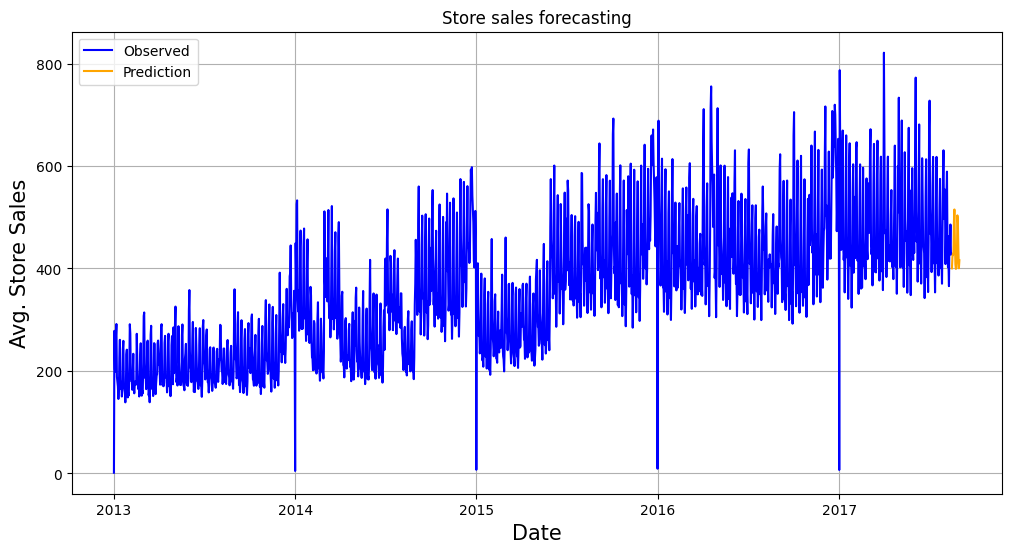

In [96]:
plt.figure(figsize=(12, 6))
plt.plot(y.index, y, label="Observed", color='blue')
plt.plot(output['date'], output['sales'], label="Prediction", color='orange')

# Confidence Interval
#plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3)

# Labels and title
plt.xlabel("Date",fontsize=15)
plt.ylabel("Avg. Store Sales",fontsize=15)
plt.title("Store sales forecasting")
plt.legend()
plt.grid()
plt.show()